In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [68]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 25  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [ ]:
X_train, Y_train, X_test, Y_test, word_to_index = load_data(train_data, test_data, vocab_size)

In [49]:
print(len(X_train))
print(len(X_test))

146182
49157


In [50]:
# detokenizer 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [51]:
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

In [52]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [53]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리


In [54]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [55]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [56]:
print(X_train[0])
print(X_train[1])

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
[1028    4   11  519  549  687    5  120    4   70 1639   52  925 1006
   15   44  391    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [63]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
#word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(512, activation = 'relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               1083392   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,571,841
Trainable params: 1,571,841
Non-trainable params: 0
_________________________________________________________________


In [36]:
print(X_train.shape)
print(Y_train.shape)

(146182, 41)
(146182,)


In [57]:
train_idx = 30000

x_train = X_train[:train_idx]
x_val = X_train[train_idx:]

y_train = Y_train[:train_idx]
y_val = Y_train[train_idx:]

In [58]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(30000, 41)
(30000,)
(116182, 41)
(116182,)


In [70]:
epochs = 10

In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/10
59/59 - 21s - loss: 0.1239 - accuracy: 0.9604 - val_loss: 71.4356 - val_accuracy: 0.8015
Epoch 2/10
59/59 - 19s - loss: 0.0909 - accuracy: 0.9711 - val_loss: 20.2849 - val_accuracy: 0.7995
Epoch 3/10
59/59 - 20s - loss: 0.0841 - accuracy: 0.9736 - val_loss: 1.2009 - val_accuracy: 0.7976
Epoch 4/10
59/59 - 20s - loss: 0.0813 - accuracy: 0.9744 - val_loss: 2.2590 - val_accuracy: 0.7973
Epoch 5/10
59/59 - 20s - loss: 0.0784 - accuracy: 0.9747 - val_loss: 1.2332 - val_accuracy: 0.7954
Epoch 6/10
59/59 - 20s - loss: 0.0743 - accuracy: 0.9756 - val_loss: 1.8774 - val_accuracy: 0.7930
Epoch 7/10
59/59 - 20s - loss: 0.0760 - accuracy: 0.9751 - val_loss: 39.4912 - val_accuracy: 0.7956
Epoch 8/10
59/59 - 20s - loss: 0.0745 - accuracy: 0.9745 - val_loss: 1.3459 - val_accuracy: 0.7903
Epoch 9/10
59/59 - 20s - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.8023 - val_accuracy: 0.7938
Epoch 10/10
59/59 - 20s - loss: 0.0653 - accuracy: 0.9792 - val_loss: 1.9808 - val_accuracy: 0.7884


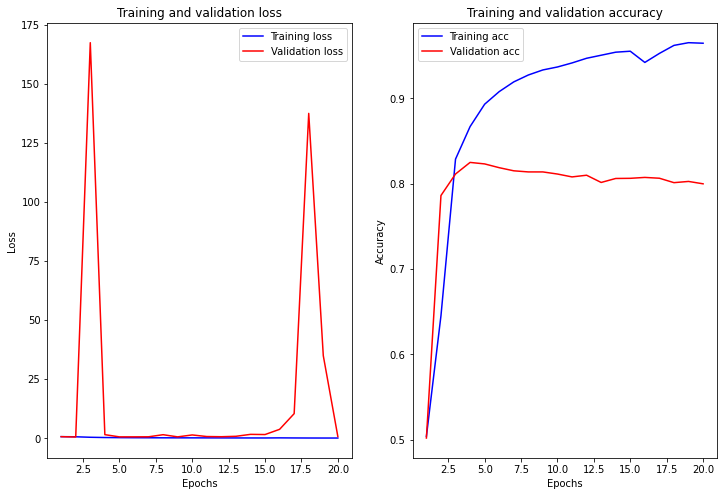

In [67]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [61]:
results = model.evaluate(X_test,  Y_test, verbose=2)

print(results)

1537/1537 - 50s - loss: 0.8336 - accuracy: 0.8009
[0.833621084690094, 0.8009235858917236]
